In [1]:
import os 
import pandas as pd
import numpy as np

from src.utils.dict_loader import TopicDictionary
from src.utils.output_loader import load_all_topvecs, load_all_bstr_arrs
from src.utils.downstream_aggregate import normalize

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 42})
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]

START2016 = pd.to_datetime(configs["START2016"])
END2016 = pd.to_datetime(configs["END2016"])
START2020 = pd.to_datetime(configs["START2020"])
END2020 = pd.to_datetime(configs["END2020"])

INPUT_FPATH = configs["DATE_TOPVEC_PATH"]
print(f"INPUT_FPATH=={INPUT_FPATH}")

OUTPUT_FPATH = ROOTPATH + "output/figs/"
print(f"OUTPUT_FPATH=={OUTPUT_FPATH}")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yijingch/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yijingch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/date-topvec-min2-gtm1/
OUTPUT_FPATH==/Users/yijingch/Documents/GITHUB/intermedia-agenda-setting/output/figs/


In [2]:
from src.utils.dict_configuration import dictionary2016, dictionary2020

TOPICS2DROP = [
    "election_campaign", "general_controversies", "no_topic", 
    "forestry", "land_water_management", "agriculture", "housing", 
    "transportation", "culture"]

TOPICS2DROP_IDX2016 = [dictionary2016.topic2index[x] for x in TOPICS2DROP]
TOPICS2DROP_IDX2020 = [dictionary2020.topic2index[x] for x in TOPICS2DROP]

Successfully loaded dictionary!
	# of unique topics: 27
	# of unique words: 1426
Successfully loaded dictionary!
	# of unique topics: 27
	# of unique words: 1453


In [3]:
topvec_dfs2016 = load_all_topvecs(year=2016, topvec_fpath=INPUT_FPATH, normalize_by_unit=True, trim=[START2016, END2016])
topvec_dfs2020 = load_all_topvecs(year=2020, topvec_fpath=INPUT_FPATH, normalize_by_unit=True, trim=[START2020, END2020])

bstr_arrs2016 = load_all_bstr_arrs(year=2016, vec_fpath=INPUT_FPATH, vec_type="topvecs", normalize_by_unit=True)
bstr_arrs2020 = load_all_bstr_arrs(year=2020, vec_fpath=INPUT_FPATH, vec_type="topvecs", normalize_by_unit=True)

In [4]:
cand_map = {
    2020:{
        "cand1": "biden", "cand2": "trump", 
        "cand_colors": {"cand1": "#64809a", "cand2": "#a74234"},
        "cand_cmaps": {"cand1": "Blues", "cand2": "Reds"}
    },
    2016:{
        "cand1": "trump", "cand2": "clinton",
        "cand_colors": {"cand2": "#64809a", "cand1": "#a74234"},
        "cand_cmaps": {"cand2": "Blues", "cand1": "Reds"}
    },
}

In [5]:
# LOAD EVENTS 
events = pd.read_csv("../../index/events.tsv", sep="\t")
events["start_date"] = pd.to_datetime(events["start_date"])
events["end_date"] = pd.to_datetime(events["end_date"])
events["year"] = events["start_date"].map(lambda x: x.year)
events_2016 = events[events["year"]==2016].reset_index()
events_2020 = events[events["year"]==2020].reset_index()

COLORMAP = {
    "low-cred": "#E55807",
    "traditional": "#445069",
    "left": "#4A55A2",
    "right": "#B31312", 
    "DEM": "#4A55A2",
    "REP": "#B31312", 
    "NA":"white"
}

## Visaulize single topic

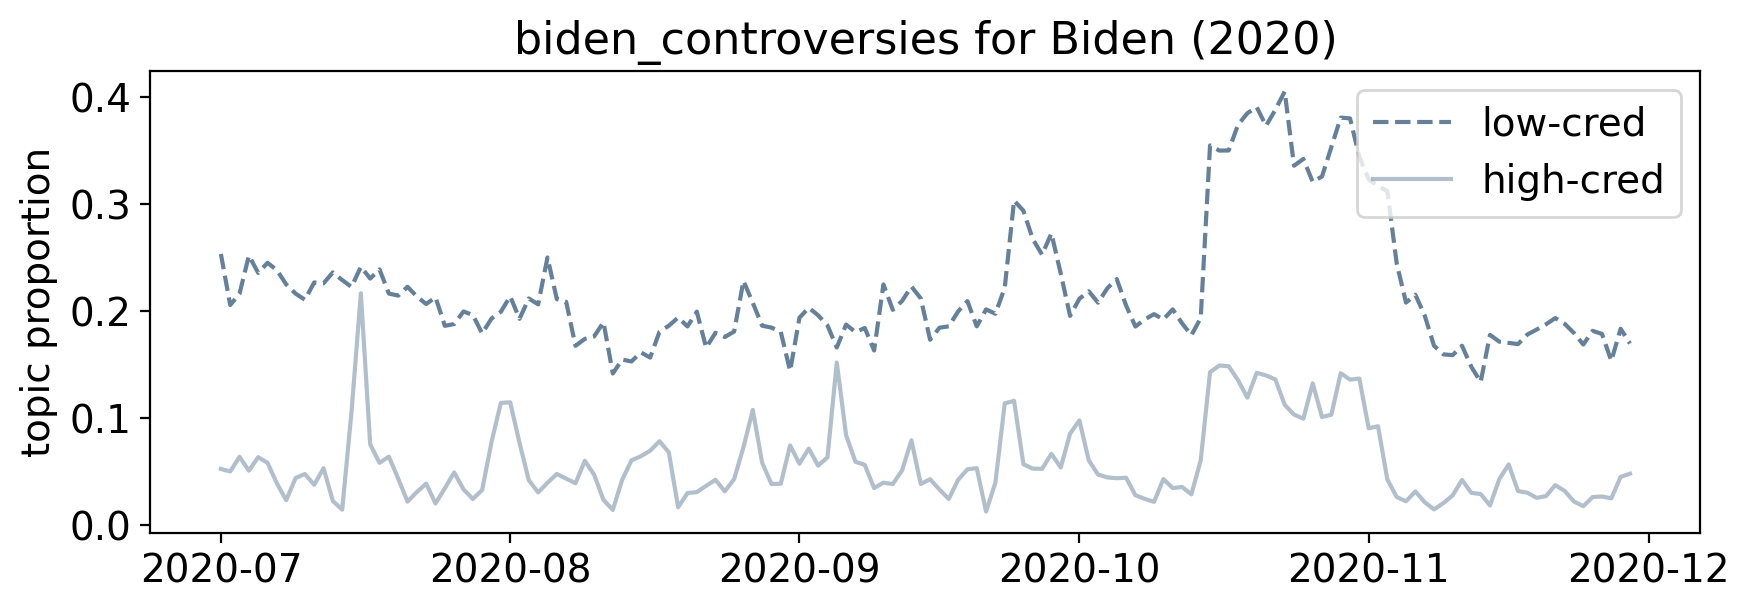

In [10]:
year = 2020
topvec_dfs = topvec_dfs2020
events_year = events_2020
dictionary = dictionary2020
topic = "biden_controversies"
cand_idx = 1
cand = f"cand{cand_idx}"
cand_name = cand_map[year][cand]

import matplotlib.cm as cm

DATES = topvec_dfs["headline"][0][0]["date"].tolist()

topvec_df_lowc = topvec_dfs["headline"][cand_idx-1][1]
topvec_df_trad = topvec_dfs["headline"][cand_idx-1][2]

topvec_ts_lowc = np.array(topvec_df_lowc.majority_topvec.tolist())[:,dictionary.topic2index[topic]]
topvec_ts_trad = np.array(topvec_df_trad.majority_topvec.tolist())[:,dictionary.topic2index[topic]]

color = cand_map[year]["cand_colors"][cand]
fig,ax = plt.subplots(figsize=(10,3), sharex=True)
ax.plot(DATES, topvec_ts_lowc, color=color, linestyle="--", label=f"low-cred")
# ax2 = ax.twinx()
# ax.set_ylabel("% topic in low-cred media", fontsize=12)
ax.set_ylabel("topic proportion", fontsize=14)
ax.plot(DATES, topvec_ts_trad, color=color, alpha=.5, label=f"high-cred")
# ax2.plot(DATES, topvec_ts_tweet, color=color, label=f"tweet - {cand_name}")
ax.set_title(f"{topic} for {cand_name.capitalize()} ({year})", fontsize=16)
# ax.plot(DATES, [-3]*len(DATES), color=color, label=f"high-cred")
ax.legend(loc=1, fontsize=14)
# ax.set_ylim(0.065, 0.185)
# ax2.set_ylim(-0.02, 0.4)
# for i,row in events_year.iterrows():
#     ax.axvspan(row["start_date"], row["end_date"]+pd.DateOffset(1), 
#                 alpha=0.2, label=row["event"], color=cm.jet(i/(len(events_year))))
# ax.legend(bbox_to_anchor=(1.08, 1.05))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(OUTPUT_FPATH + f"{topic}_{cand_name}_ts_{year}.pdf", dpi=500, bbox_inches="tight")